In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import os
import scipy.signal # power spectral density fxn.
import datetime
import socket
import glob

In [2]:
#file_list = glob.glob('IN_h5/1chfw_1000tones_direct*seconds.hd5') #test file
# file_list = glob.glob('./*.hd5') #all hd5 file in input directory
import socket
addr = ("192.168.3.40", 4096)
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind(addr)
sock.settimeout(3)

def parse_packet():
    data = sock.recv(8192)
    if len(data) <  8000:
        print("invalid packet recieved")
        return
    datarray = bytearray(data)

    # now allow a shift of the bytes
    spec_data = np.frombuffer(datarray, dtype = '<i', offset=0x00)
    # offset allows a shift in the bytes
    return spec_data # int32 data type

def capture_packets(N_packets):
    # toss out buffer data
    for i in range(2000):
        parse_packet()
    packets = np.zeros(shape=(2048,N_packets))
    #packets = np.zeros(shape=(2051,N_packets))
    counter = 0
    for i in range(N_packets):
        data_2 = parse_packet()
        packets[:,i] = data_2 
        if i%488 == 0:
            print("{}/{} captured ({:.3f}% Complete)".format(i, N_packets, 
                (i/N_packets)*100.0))
    print("{}/{} captured ({:.3f}% Complete)".format(N_packets, N_packets, (N_packets/N_packets)*100.0))
    return packets
    

In [17]:
data = None
try:
    data = capture_packets(488*40)
except TimeoutError:
    raise TimeoutError("Are we receiving data and are the MAC addresses correct?")
    sock.close()
I=data[::2]
Q=data[1::2]
filename = "transceiver_brownlid_aftertuning_100tones_1-22"
#filename = "exclaimifloopback-10tones-1ghzlo-29-dbatten"
np.save(filename, np.array((I,Q)))

0/19520 captured (0.000% Complete)
488/19520 captured (2.500% Complete)
976/19520 captured (5.000% Complete)
1464/19520 captured (7.500% Complete)
1952/19520 captured (10.000% Complete)
2440/19520 captured (12.500% Complete)
2928/19520 captured (15.000% Complete)
3416/19520 captured (17.500% Complete)
3904/19520 captured (20.000% Complete)
4392/19520 captured (22.500% Complete)
4880/19520 captured (25.000% Complete)
5368/19520 captured (27.500% Complete)
5856/19520 captured (30.000% Complete)
6344/19520 captured (32.500% Complete)
6832/19520 captured (35.000% Complete)
7320/19520 captured (37.500% Complete)
7808/19520 captured (40.000% Complete)
8296/19520 captured (42.500% Complete)
8784/19520 captured (45.000% Complete)
9272/19520 captured (47.500% Complete)
9760/19520 captured (50.000% Complete)
10248/19520 captured (52.500% Complete)
10736/19520 captured (55.000% Complete)
11224/19520 captured (57.500% Complete)
11712/19520 captured (60.000% Complete)
12200/19520 captured (62.500% 

In [18]:
#filename = 'mgb2_noise_data_983p1mhz_loopback_488x4_4p8K_no_signal'
I,Q = np.load(filename + '.npy')
I

array([[-14128384., -16566528., -13376000., ..., -17373184., -13515008.,
        -17316096.],
       [-14128129., -16566273., -13375745., ..., -17372929., -13514753.,
        -17315841.],
       [-14128129., -16566273., -13375745., ..., -17372929., -13514753.,
        -17315841.],
       ...,
       [        0.,         0.,         0., ...,         0.,         0.,
                0.],
       [        0.,         0.,         0., ...,         0.,         0.,
                0.],
       [        0.,         0.,         0., ...,         0.,         0.,
                0.]])

In [19]:
def template(I,Q):
    # subtract the mean from each detector
    Imeansub = np.zeros_like(I)
    Qmeansub = np.zeros_like(Q)
    for i in range(len(I[:,0])):
        Imeansub[i,:] = I[i,:] - np.mean(I[i,:])
        Qmeansub[i,:] = Q[i,:] - np.mean(Q[i,:])
    
    # select only the middle few detectors
    deproj_I = Imeansub[9:14,:]
    deproj_Q = Qmeansub[9:14,:]

    # create a separate correlation matrix for I and Q
    correlation_matrix_I = np.matmul(deproj_I,np.conj(np.transpose(deproj_I)))
    correlation_matrix_Q = np.matmul(deproj_Q,np.conj(np.transpose(deproj_Q)))
    # calculate the eigenmodes of each correlation matrix
    wI,vI = np.linalg.eig(correlation_matrix_I)
    wQ,vQ = np.linalg.eig(correlation_matrix_Q)
    # create templates based on the largest eigenmode of each
    templateI0 = np.matmul(vI[:,0],deproj_I)    
    templateQ0 = np.matmul(vQ[:,0],deproj_Q)

    # subtract the mean again to be sure
    template_real0 = np.real(templateI0)-np.mean(np.real(templateI0))
    template_imag0 = np.real(templateQ0)-np.mean(np.real(templateQ0))

    # create templates based on the second largest eigenmode of each
    templateI1 = np.matmul(vI[:,1],deproj_I)    
    templateQ1 = np.matmul(vQ[:,1],deproj_Q)

    # subtract the mean again to be sure
    template_real1 = np.real(templateI1)-np.mean(np.real(templateI1))
    template_imag1 = np.real(templateQ1)-np.mean(np.real(templateQ1))
   
    #plt.figure()
    #plt.subplot(2,1,1)
    #plt.semilogy(wI,"x")
    #plt.grid("on")
    #plt.subplot(2,1,2)
    #plt.semilogy(wQ,"x")
    #plt.grid("on")
    
    return template_real0,template_imag0,template_real1,template_imag1


In [20]:
def clean(I,Q,template_I0,template_Q0,template_I1,template_Q1):
    Iclean = np.zeros_like(I)
    Qclean = np.zeros_like(Q)
    
    for idet in range(len(I[:,0])):
        samp_chan_I = I[idet,:]
        samp_chan_Q = Q[idet,:]
    
        corr0 = np.matmul(samp_chan_I,np.transpose(template_I0))/np.matmul(template_I0,np.transpose(template_I0))
        deprojected_samp_detector_I = samp_chan_I-corr0*template_I0
        corr1 = np.matmul(deprojected_samp_detector_I,np.transpose(template_I1))/np.matmul(template_I1,np.transpose(template_I1))
        deprojected_samp_detector_I = deprojected_samp_detector_I-corr1*template_I1
        
        corr0 = np.matmul(samp_chan_Q,np.transpose(template_Q0))/np.matmul(template_Q0,np.transpose(template_Q0))
        deprojected_samp_detector_Q = samp_chan_Q-corr0*template_Q0
        corr1 = np.matmul(deprojected_samp_detector_Q,np.transpose(template_Q1))/np.matmul(template_Q1,np.transpose(template_Q1))
        deprojected_samp_detector_Q = deprojected_samp_detector_Q-corr1*template_Q1
    
        Iclean[idet,:] = deprojected_samp_detector_I
        Qclean[idet,:] = deprojected_samp_detector_Q
    return Iclean,Qclean


In [21]:
def noise_plot(I,Q,npoints,file):
    # initialize variables
    nfs = int(np.log2(npoints))
    f_interp = np.zeros(nfs)
    Spp_i_interp = np.zeros((1024,nfs))
    Spp_q_interp = np.zeros((1024,nfs))
    Spp_interp = np.zeros((1024,nfs))

    # find the power in each detector
    rms_per_det = np.std(I,axis=1) + np.std(Q,axis=1)
    # find the detector with median power
    idet_median = np.argsort(rms_per_det)[int(len(rms_per_det)/2)]
    
    #for idet in range(4,14):
    for idet in range(len(I[:,0])):
        # form the complex signal of this detector
        Z = I[idet,:] + 1j*Q[idet,:]

        # calculate the DC value for this detector
        norm = np.mean(np.abs(Z))

        # take the Welch periodogram (viewer-friendly FFT)
        # of the real and imaginary parts of the signal
        f,Spp_i=scipy.signal.welch(np.real(Z)/norm,fs=512e6/2**(10+8),nperseg=npoints)
        f,Spp_q=scipy.signal.welch(np.imag(Z)/norm,fs=512e6/2**(10+8),nperseg=npoints)

        # smooth the curve further for plotting
        for j in range(0,nfs-1):
            f_interp[j] = np.mean(f[2**j:2**(j+1)])
            Spp_i_interp[idet,j] = np.mean(Spp_i[2**j:2**(j+1)])
            Spp_q_interp[idet,j] = np.mean(Spp_q[2**j:2**(j+1)])

        # combine I and Q spectra for plotting
        Spp_interp[idet,:] = (Spp_i_interp[idet,:] + Spp_q_interp[idet,:])/2

        # plot this detector
        #plt.semilogx(f_interp[:],10*np.log10(Spp_i_interp[idet,:])[:],"-",color="blue",alpha=0.5)#,label="All Detectors")
        #plt.semilogx(f_interp[:],10*np.log10(Spp_q_interp[idet,:])[:],"-",color="orange",alpha=0.5)#,label="All Detectors")
        # plot non smoothed data
        plt.semilogx(f[:],10*np.log10(Spp_i[:])[:],"-",color="blue",alpha=0.5)#,label="All Detectors")
        plt.semilogx(f[:],10*np.log10(Spp_q[:])[:],"-",color="orange",alpha=0.5)#,label="All Detectors")
        # if we are at the detector with median power
        if idet == idet_median:
            # plot this again, but with a solid black line to highlight it
            plt.semilogx(f_interp[:],10*np.log10(Spp_interp[idet,:])[:],"-",color="black",alpha=1.00,label="Median Detectors")
    
    # fname = 'OUT/'+file.split('/')[1].split('.')[0]
    fname = filename + '.png'
    #fname = filename
    # plt.figure(figsize=(12,8))
    plt.title("" + fname)# 20-900 Channel 2")
    plt.ylabel(r"$S_{\phi \phi}$ [dBc/Hz]", fontsize=16); 
    plt.xlabel("Hz", fontsize=16)
    plt.ylim(-150,-10)
    #plt.yticks(np.linspace(-110, -50, abs(110-50)-1))
    plt.grid()
    plt.savefig(fname)
    plt.show()
    print(filename)
    return

for file in file_list:
    f = h5py.File(file, 'r') #read file
    t = f['time_ordered_data'] #take out just time ordered part of h5
    I = t['adc_i'][:]
    Q = t['adc_q'][:]
    template_I0,template_Q0,template_I1,template_Q1 = template(I,Q) #create templates from first two modes
    Iclean,Qclean = clean(I,Q,template_I0,template_Q0,template_I1,template_Q1) #subtract both modes from I and Q
    npoints = 8192
    noise_plot(Iclean,Qclean,npoints,file) #make diagnotstic noise plot of all detectors

In [22]:
template_I0,template_Q0,template_I1,template_Q1 = template(I,Q) #create templates from first two modes
Iclean,Qclean = clean(I,Q,template_I0,template_Q0,template_I1,template_Q1) #subtract both modes from I and Q
npoints = 8192

/tmp/ipykernel_219186/3934028643.py:45: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(f_interp[:],10*np.log10(Spp_interp[idet,:])[:],"-",color="black",alpha=1.00,label="Median Detectors")


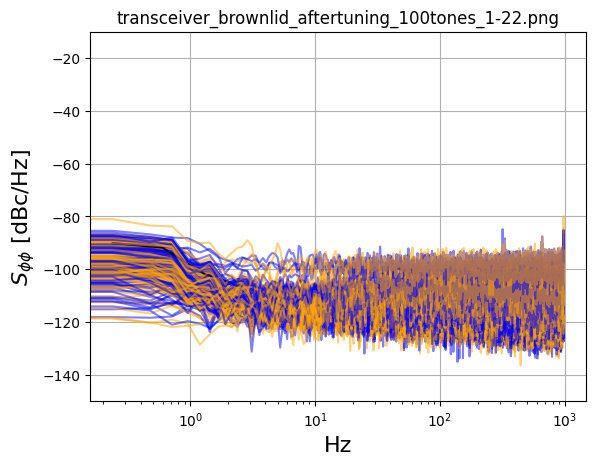

transceiver_brownlid_aftertuning_100tones_1-22


In [23]:
noise_plot(Iclean[8:108],Qclean[8:108],npoints,"") #make d

In [ ]:
#test a single file
##f = h5py.File(file_list[12], 'r')
##t = f['time_ordered_data']
##I = t['adc_i'][:]
##Q = t['adc_q'][:]
##template_I0,template_Q0,template_I1,template_Q1 = template(I,Q)
##Iclean,Qclean = clean(I,Q,tempdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAiMAAAGsCAYAAAAPJKchAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8WgzjOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAqdUlEQVR4nO3df3QV9Z3/8ddNIDegJBRjfmEw0QqKQIjYpNFyFjQaIhvl7G6laAWzSleWnAWz7kJWIaa2xl9QWhtJRSG6roBYxVo4QYxGKsayELKFohQwAsXcBOSQhNAkmDvfP/hy9ZqfE3Lzyb15Ps6Zc7xzP/OZ9zDM4eXnznzGYVmWJQAAAEOCTBcAAAAGNsIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMMqvwsi2bduUmZmp2NhYORwObdy40db2TU1NuvfeezV+/HgNGjRIM2bMaNOmrKxMDoejzeJyuXrnIAAAgBe/CiONjY1KTExUYWFhj7ZvbW3VkCFD9G//9m9KS0vrtO3+/ftVXV3tWSIjI3u0TwAA0LlBpguwIyMjQxkZGR1+39zcrIcfflhr167VqVOnNG7cOD355JOaMmWKJOmiiy7SypUrJUnbt2/XqVOnOuwrMjJSw4cP78XqAQBAe/xqZKQr2dnZKi8v17p16/SnP/1JP/zhDzVt2jQdOHDAdl8TJ05UTEyMbrnlFm3fvt0H1QIAACmAwsiRI0e0Zs0abdiwQZMnT9aVV16phx56SD/4wQ+0Zs2abvcTExOjoqIi/fa3v9Vvf/tbxcXFacqUKaqoqPBh9QAADFx+9TNNZ/bs2aPW1laNHj3aa31zc7MuueSSbvczZswYjRkzxvP5hhtu0KFDh/SLX/xC//3f/91r9QIAgHMCJoycPn1awcHB2rVrl4KDg72+u/jiiy+o7+TkZH344YcX1AcAAGhfwISRpKQktba2qra2VpMnT+7VvisrKxUTE9OrfQIAgHP8KoycPn1aBw8e9HyuqqpSZWWlRowYodGjR+vuu+/W7NmztWzZMiUlJen48eMqLS3VhAkTNH36dEnSvn371NLSopMnT6qhoUGVlZWSzt2wKkkrVqxQQkKCrr32WjU1NemFF17Qe++9p3feeaevDxcAgAHBYVmWZbqI7iorK9PUqVPbrJ8zZ46Ki4t19uxZ/exnP9PLL7+sY8eOKSIiQt///veVn5+v8ePHS5Li4+N1+PDhNn2c/2N46qmn9Pzzz+vYsWMaOnSoJkyYoKVLl7a7XwAAcOH8KowAAIDAEzCP9gIAAP9EGAEAAEb5xQ2sbrdbX3zxhYYNGyaHw2G6HAAA0A2WZamhoUGxsbEKCup4/MMvwsgXX3yhuLg402UAAIAeOHr0qC677LIOv/eLMDJs2DBJ5w4mLCzMcDUAAKA76uvrFRcX5/l3vCN+EUbO/zQTFhZGGAEAwM90dYsFN7ACAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjPKLSc8A+IdWt6UdVSdV29CkyGGhSk4YoeAg3icFoHOEEQC9omRvtfLf3qfquibPupjwUOVljtW0cTEGKwPQ3/EzDYALVrK3WvNeqfAKIpLkqmvSvFcqVLK32lBlAPwBYQTABWl1W8p/e5+sdr47vy7/7X1qdbfXAgAIIwAu0I6qk21GRL7JklRd16QdVSf7rigAfoUwAuCC1DZ0HER60g7AwGM7jGzbtk2ZmZmKjY2Vw+HQxo0bu73t9u3bNWjQIE2cONHubgH0U5HDQnu1HYCBx3YYaWxsVGJiogoLC21td+rUKc2ePVs333yz3V0C6MeSE0YoJjxUHT3A69C5p2qSE0b0ZVkA/IjtR3szMjKUkZFhe0cPPPCA7rrrLgUHB9saTQHQvwUHOZSXOVbzXqmQQ/K6kfV8QMnLHMt8IwA61Cf3jKxZs0afffaZ8vLyutW+ublZ9fX1XguA/mvauBit/PF1igxzeq2PDg/Vyh9fxzwjADrl80nPDhw4oMWLF+sPf/iDBg3q3u4KCgqUn5/v48oA9KZp42J043cjNP7RdyRJxVnf0+SrLmVEBECXfDoy0traqrvuukv5+fkaPXp0t7fLzc1VXV2dZzl69KgPqwTQW74ZPJgKHkB3+XRkpKGhQTt37tTu3buVnZ0tSXK73bIsS4MGDdI777yjm266qc12TqdTTqezzXoAABB4fBpGwsLCtGfPHq91zz33nN577z29/vrrSkhI8OXuAQCAH7AdRk6fPq2DBw96PldVVamyslIjRozQqFGjlJubq2PHjunll19WUFCQxo0b57V9ZGSkQkND26wHAAADk+0wsnPnTk2dOtXzOScnR5I0Z84cFRcXq7q6WkeOHOm9CgEAQEBzWJbV799eVV9fr/DwcNXV1SksLMx0OQA6cKblK41dukWStO+n6Roa4vMH9gD0Y93995t30wAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIyyHUa2bdumzMxMxcbGyuFwaOPGjZ22f+ONN3TLLbfo0ksvVVhYmFJTU7Vly5ae1gsAAAKM7TDS2NioxMREFRYWdqv9tm3bdMstt2jz5s3atWuXpk6dqszMTO3evdt2sQAAIPAMsrtBRkaGMjIyut1+xYoVXp8ff/xxvfXWW3r77beVlJRkd/cAACDA2A4jF8rtdquhoUEjRozosE1zc7Oam5s9n+vr6/uiNAAAYECf38D6zDPP6PTp07rzzjs7bFNQUKDw8HDPEhcX14cVAgCAvtSnYeTVV19Vfn6+XnvtNUVGRnbYLjc3V3V1dZ7l6NGjfVglAADoS332M826det0//33a8OGDUpLS+u0rdPplNPp7KPKAACASX0yMrJ27VplZWVp7dq1mj59el/sEgAA+AnbIyOnT5/WwYMHPZ+rqqpUWVmpESNGaNSoUcrNzdWxY8f08ssvSzr308ycOXP0y1/+UikpKXK5XJKkIUOGKDw8vJcOAwAA+CvbIyM7d+5UUlKS57HcnJwcJSUlaenSpZKk6upqHTlyxNP++eef11dffaX58+crJibGsyxYsKCXDgEAAPgz2yMjU6ZMkWVZHX5fXFzs9bmsrMzuLgAAwADCu2kAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGDUINMFAEB3tbot7ag6qdqGJkUOC1VywggFBzlMlwXgAhFGAPiFkr3Vyn97n6rrmjzrYsJDlZc5VtPGxRisDMCF4mcaAP1eyd5qzXulwiuISJKrrknzXqlQyd5qQ5UB6A2EEQD9WqvbUv7b+2S18935dflv71Oru70WAPwBYQRAv7aj6mSbEZFvsiRV1zVpR9XJvisKQK8ijADo12obOg4iPWkHoP8hjADo1yKHhfZqOwD9D2EEQL+WnDBCMeGh6ugBXofOPVWTnDCiL8sC0IsIIwD6teAgh/Iyx0pSm0By/nNe5ljmGwH8GGEEQL83bVyMVv74OkWGOb3WR4eHauWPr2OeEcDPMekZAL8wbVyMbvxuhMY/+o4kqTjre5p81aWMiAABgJERAH7jm8GDqeCBwEEYAQAARhFGAACAUdwzAgDijcCASYQRAAMebwQGzOJnGgADGm8EBswjjAAYsHgjMNA/EEYADFi8ERjoHwgjAAYs3ggM9A+EEQADFm8EBvoHwgiAAYs3AgP9g+0wsm3bNmVmZio2NlYOh0MbN27scpuysjJdd911cjqd+u53v6vi4uIelAoAvYs3AgP9g+0w0tjYqMTERBUWFnarfVVVlaZPn66pU6eqsrJSCxcu1P33368tW7bYLhYAehtvBAbMsz3pWUZGhjIyMrrdvqioSAkJCVq2bJkk6ZprrtGHH36oX/ziF0pPT7e7ewDodX3xRmBmeAU65vMZWMvLy5WWlua1Lj09XQsXLuxwm+bmZjU3N3s+19fX+6o8AJDk2zcCM8Mr0Dmf38DqcrkUFRXltS4qKkr19fX629/+1u42BQUFCg8P9yxxcXG+LhMAfIIZXoGu9cunaXJzc1VXV+dZjh49arokALCNGV6B7vH5zzTR0dGqqanxWldTU6OwsDANGTKk3W2cTqecTme73wGAv7Azw2vqlZf0XWFAP+PzkZHU1FSVlpZ6rdu6datSU1N9vWsAMIoZXoHusR1GTp8+rcrKSlVWVko69+huZWWljhw5IuncTyyzZ8/2tH/ggQf02Wef6T//8z/16aef6rnnntNrr72mBx98sHeOAAD6KWZ4BbrHdhjZuXOnkpKSlJSUJEnKyclRUlKSli5dKkmqrq72BBNJSkhI0KZNm7R161YlJiZq2bJleuGFF3isF0DAY4ZXoHts3zMyZcoUWVbHN1u1N7vqlClTtHv3bru7AgC/dn6G13mvVMghed3I2tszvDKPCfyZz29gBYCB7PwMr3m/+7Nq6r+ePym6F+cZYR4T+DvCCAD4mC9neD0/j8m3x6vPz2PSW1PaM/ICXyKMAEAf8MUMr13NY+LQuXlMbhkbfUH7Y+QFvtYvJz0DAHTNzjwmPcUMsugLhBFgAGl1Wyo/9KXeqjym8kNfMvOnn/P1PCbMIIu+ws80wADBUHvg8fU8Jswgi77CyAgwADDUHph8PY8JM8iirxBGgADHUHvgOj+PiaQ2gaQ35jFhBln0FcIIEOD64iZHmHN+HpPIMO+Xi0aHh17wY73MIIu+QhgBAhxD7YFv2rgYvZvzd57PxVnf04eLbrrge4F8PfICnEcYAQIcQ+0Dgy/mMZF8O/ICnMfTNECAOz/U7qprave+EYfO/cPCUDs64ssZZAGJkREg4DHUjt7gq5EXQCKMAAMCQ+0A+jN+pgEGCIbaAfRXjIwAAwhD7QD6I8IIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMKpHYaSwsFDx8fEKDQ1VSkqKduzY0Wn7FStWaMyYMRoyZIji4uL04IMPqqmpqUcFAwCAwGI7jKxfv145OTnKy8tTRUWFEhMTlZ6ertra2nbbv/rqq1q8eLHy8vL0ySef6MUXX9T69ev1X//1XxdcPAAA8H+2w8jy5cs1d+5cZWVlaezYsSoqKtLQoUO1evXqdtt/9NFHuvHGG3XXXXcpPj5et956q2bNmtXlaAoAABgYbIWRlpYW7dq1S2lpaV93EBSktLQ0lZeXt7vNDTfcoF27dnnCx2effabNmzfrtttu63A/zc3Nqq+v91oAAEBgGmSn8YkTJ9Ta2qqoqCiv9VFRUfr000/b3eauu+7SiRMn9IMf/ECWZemrr77SAw880OnPNAUFBcrPz7dTGgAA8FM+f5qmrKxMjz/+uJ577jlVVFTojTfe0KZNm/TYY491uE1ubq7q6uo8y9GjR31dJgAAMMTWyEhERISCg4NVU1Pjtb6mpkbR0dHtbrNkyRLdc889uv/++yVJ48ePV2Njo37yk5/o4YcfVlBQ2zzkdDrldDrtlAYAAPyUrZGRkJAQTZo0SaWlpZ51brdbpaWlSk1NbXebM2fOtAkcwcHBkiTLsuzWCwAAAoytkRFJysnJ0Zw5c3T99dcrOTlZK1asUGNjo7KysiRJs2fP1siRI1VQUCBJyszM1PLly5WUlKSUlBQdPHhQS5YsUWZmpieUAACAgct2GJk5c6aOHz+upUuXyuVyaeLEiSopKfHc1HrkyBGvkZBHHnlEDodDjzzyiI4dO6ZLL71UmZmZ+vnPf957RwEAAPyW7TAiSdnZ2crOzm73u7KyMu8dDBqkvLw85eXl9WRXAAAgwPFuGgAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFE9CiOFhYWKj49XaGioUlJStGPHjk7bnzp1SvPnz1dMTIycTqdGjx6tzZs396hgAAAQWAbZ3WD9+vXKyclRUVGRUlJStGLFCqWnp2v//v2KjIxs076lpUW33HKLIiMj9frrr2vkyJE6fPiwhg8f3hv1AwAAP2c7jCxfvlxz585VVlaWJKmoqEibNm3S6tWrtXjx4jbtV69erZMnT+qjjz7S4MGDJUnx8fEXVjUAAAgYtn6maWlp0a5du5SWlvZ1B0FBSktLU3l5ebvb/O53v1Nqaqrmz5+vqKgojRs3To8//rhaW1s73E9zc7Pq6+u9FgAAEJhshZETJ06otbVVUVFRXuujoqLkcrna3eazzz7T66+/rtbWVm3evFlLlizRsmXL9LOf/azD/RQUFCg8PNyzxMXF2SkTAAD4EZ8/TeN2uxUZGannn39ekyZN0syZM/Xwww+rqKiow21yc3NVV1fnWY4ePerrMgEAgCG27hmJiIhQcHCwampqvNbX1NQoOjq63W1iYmI0ePBgBQcHe9Zdc801crlcamlpUUhISJttnE6nnE6nndIAAICfsjUyEhISokmTJqm0tNSzzu12q7S0VKmpqe1uc+ONN+rgwYNyu92edX/5y18UExPTbhABAAADi+2faXJycrRq1Sq99NJL+uSTTzRv3jw1NjZ6nq6ZPXu2cnNzPe3nzZunkydPasGCBfrLX/6iTZs26fHHH9f8+fN77ygAAIDfsv1o78yZM3X8+HEtXbpULpdLEydOVElJieem1iNHjigo6OuMExcXpy1btujBBx/UhAkTNHLkSC1YsECLFi3qvaMAAAB+y3YYkaTs7GxlZ2e3+11ZWVmbdampqfr44497sisAABDgeDcNAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwqkdhpLCwUPHx8QoNDVVKSop27NjRre3WrVsnh8OhGTNm9GS3AAAgANkOI+vXr1dOTo7y8vJUUVGhxMREpaenq7a2ttPtPv/8cz300EOaPHlyj4sFAACBx3YYWb58uebOnausrCyNHTtWRUVFGjp0qFavXt3hNq2trbr77ruVn5+vK6644oIKBgAAgcVWGGlpadGuXbuUlpb2dQdBQUpLS1N5eXmH2/30pz9VZGSk7rvvvm7tp7m5WfX19V4LAAAITLbCyIkTJ9Ta2qqoqCiv9VFRUXK5XO1u8+GHH+rFF1/UqlWrur2fgoIChYeHe5a4uDg7ZQIAAD/i06dpGhoadM8992jVqlWKiIjo9na5ubmqq6vzLEePHvVhlQAAwKRBdhpHREQoODhYNTU1XutramoUHR3dpv2hQ4f0+eefKzMz07PO7Xaf2/GgQdq/f7+uvPLKNts5nU45nU47pQEAAD9la2QkJCREkyZNUmlpqWed2+1WaWmpUlNT27S/+uqrtWfPHlVWVnqW22+/XVOnTlVlZSU/vwAAAHsjI5KUk5OjOXPm6Prrr1dycrJWrFihxsZGZWVlSZJmz56tkSNHqqCgQKGhoRo3bpzX9sOHD5ekNusBAMDAZDuMzJw5U8ePH9fSpUvlcrk0ceJElZSUeG5qPXLkiIKCmNgVAAB0j+0wIknZ2dnKzs5u97uysrJOty0uLu7JLgEAQIBiCAMAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGEUYAQAARhFGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGBUj8JIYWGh4uPjFRoaqpSUFO3YsaPDtqtWrdLkyZP1ne98R9/5zneUlpbWaXsAADCw2A4j69evV05OjvLy8lRRUaHExESlp6ertra23fZlZWWaNWuW3n//fZWXlysuLk633nqrjh07dsHFAwAA/2c7jCxfvlxz585VVlaWxo4dq6KiIg0dOlSrV69ut/3//M//6F//9V81ceJEXX311XrhhRfkdrtVWlp6wcUDAAD/ZyuMtLS0aNeuXUpLS/u6g6AgpaWlqby8vFt9nDlzRmfPntWIESM6bNPc3Kz6+nqvBQAABCZbYeTEiRNqbW1VVFSU1/qoqCi5XK5u9bFo0SLFxsZ6BZpvKygoUHh4uGeJi4uzUyYAAPAjffo0zRNPPKF169bpzTffVGhoaIftcnNzVVdX51mOHj3ah1UCAIC+NMhO44iICAUHB6umpsZrfU1NjaKjozvd9plnntETTzyhd999VxMmTOi0rdPplNPptFMaAADwU7ZGRkJCQjRp0iSvm0/P34yampra4XZPPfWUHnvsMZWUlOj666/vebUAACDg2BoZkaScnBzNmTNH119/vZKTk7VixQo1NjYqKytLkjR79myNHDlSBQUFkqQnn3xSS5cu1auvvqr4+HjPvSUXX3yxLr744l48FAAA4I9sh5GZM2fq+PHjWrp0qVwulyZOnKiSkhLPTa1HjhxRUNDXAy4rV65US0uL/umf/smrn7y8PD366KMXVj0AAPB7tsOIJGVnZys7O7vd78rKyrw+f/755z3ZBQAAGCB4Nw0AADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjCCMAAMAowggAADCKMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwijACAACMIowAAACjBpkuwJRWt6UdVSdV29CkyGGhSk4YoeAgB/37uG/6N9c30F/58zXr6/79uXY7ehRGCgsL9fTTT8vlcikxMVHPPvuskpOTO2y/YcMGLVmyRJ9//rmuuuoqPfnkk7rtttt6XPSFKtlbrfy396m6rsmzLiY8VHmZYzVtXMyA7t+fa/f3/n1dO9Af+fM16+v+/bl2u2z/TLN+/Xrl5OQoLy9PFRUVSkxMVHp6umpra9tt/9FHH2nWrFm67777tHv3bs2YMUMzZszQ3r17L7j4nijZW615r1R4/eFLkquuSfNeqVDJ3uoB278/1+7v/fu6dqA/8udr1tf9+3PtPWF7ZGT58uWaO3eusrKyJElFRUXatGmTVq9ercWLF7dp/8tf/lLTpk3Tf/zHf0iSHnvsMW3dulW//vWvVVRUdIHl29PqtpT/9j5ZkmRZcra2eH3vkFTwxm7dHB/Wo2GqVrelgjd2K+Sr5na/78/9+3Pt/t6/r2v/JnfLV3L+//24z5yR+6ve/aXWn/v359r9sX9/vmZ93b+p2puDQ2Q5HHJIyn97n24ZG91nP9k4LMuyutu4paVFQ4cO1euvv64ZM2Z41s+ZM0enTp3SW2+91WabUaNGKScnRwsXLvSsy8vL08aNG/V///d/7e6nublZzc1f/yHV19crLi5OdXV1CgsL6265bZQf+lKzVn0sSXJ+1ayNv3+4x30BABBIZvz9z9U8yOn5vHbu95V65SUX1Gd9fb3Cw8O7/Pfb1s80J06cUGtrq6KiorzWR0VFyeVytbuNy+Wy1V6SCgoKFB4e7lni4uLslNmh2oamrhsBAIA+/TezXz5Nk5ubq5ycHM/n8yMjFypyWKjnv5uDQzTj73/ebrvirGSlJIyw3f8fq07q3jU7umzXH/v359r9vX9f1w70R/58zfq6f1O1NweHeH3+5r+ZvmYrjERERCg4OFg1NTVe62tqahQdHd3uNtHR0bbaS5LT6ZTT6ezw+55KThihmPBQueqaZDkcXsNR0rnf4aLDQ5V8zUgF9eB3suRrhmjEJeHn+m/n+/7cvz/X7u/9+7p2oD/y52vW1/33m9r78H9+bP1MExISokmTJqm0tNSzzu12q7S0VKmpqe1uk5qa6tVekrZu3dphe18KDnIoL3OspHN/2N90/nNe5tge37Djz/37c+3+3r+vawf6I3++Zn3dvz/X3lO2H+3NycnRqlWr9NJLL+mTTz7RvHnz1NjY6Hm6Zvbs2crNzfW0X7BggUpKSrRs2TJ9+umnevTRR7Vz505lZ2f33lHYMG1cjFb++DpFh3sPP0WHh2rlj6+74Ger/bl/f67d3/v3de1Af+TP16yv+/fn2nvC1tM05/3617/2THo2ceJE/epXv1JKSookacqUKYqPj1dxcbGn/YYNG/TII494Jj176qmnbE161t27ce3w91ntmPEvMPvvL7MhAn3Jn69ZX/fvz7VL3f/3u0dhpK/5IowAAADf8smjvQAAAL2NMAIAAIwijAAAAKMIIwAAwCjCCAAAMIowAgAAjCKMAAAAowgjAADAKMIIAAAwytZbe005P0lsfX294UoAAEB3nf93u6vJ3v0ijDQ0NEiS4uLiDFcCAADsamhoUHh4eIff+8W7adxut7744gsNGzZMDkfvvsAnLi5OR48eHRDvvBlIx8uxBq6BdLwca+AaKMdrWZYaGhoUGxuroKCO7wzxi5GRoKAgXXbZZT7rPywsLKD/MnzbQDpejjVwDaTj5VgD10A43s5GRM7jBlYAAGAUYQQAABg1oMOI0+lUXl6enE6n6VL6xEA6Xo41cA2k4+VYA9dAO96u+MUNrAAAIHAN6JERAABgHmEEAAAYRRgBAABGEUYAAIBRAR9GCgsLFR8fr9DQUKWkpGjHjh2dtt+wYYOuvvpqhYaGavz48dq8eXMfVXphCgoK9L3vfU/Dhg1TZGSkZsyYof3793e6TXFxsRwOh9cSGhraRxX33KOPPtqm7quvvrrTbfz1vMbHx7c5VofDofnz57fb3t/O6bZt25SZmanY2Fg5HA5t3LjR63vLsrR06VLFxMRoyJAhSktL04EDB7rs1+513xc6O9azZ89q0aJFGj9+vC666CLFxsZq9uzZ+uKLLzrtsyfXQl/o6rzee++9beqeNm1al/32x/MqdX287V3DDodDTz/9dId99tdz6ysBHUbWr1+vnJwc5eXlqaKiQomJiUpPT1dtbW277T/66CPNmjVL9913n3bv3q0ZM2ZoxowZ2rt3bx9Xbt8HH3yg+fPn6+OPP9bWrVt19uxZ3XrrrWpsbOx0u7CwMFVXV3uWw4cP91HFF+baa6/1qvvDDz/ssK0/n9f//d//9TrOrVu3SpJ++MMfdriNP53TxsZGJSYmqrCwsN3vn3rqKf3qV79SUVGR/vjHP+qiiy5Senq6mpqaOuzT7nXfVzo71jNnzqiiokJLlixRRUWF3njjDe3fv1+33357l/3auRb6SlfnVZKmTZvmVffatWs77bO/nlep6+P95nFWV1dr9erVcjgc+sd//MdO++2P59ZnrACWnJxszZ8/3/O5tbXVio2NtQoKCtptf+edd1rTp0/3WpeSkmL9y7/8i0/r9IXa2lpLkvXBBx902GbNmjVWeHh43xXVS/Ly8qzExMRutw+k87pgwQLryiuvtNxud7vf++s5tSzLkmS9+eabns9ut9uKjo62nn76ac+6U6dOWU6n01q7dm2H/di97k349rG2Z8eOHZYk6/Dhwx22sXstmNDesc6ZM8e64447bPXjD+fVsrp3bu+44w7rpptu6rSNP5zb3hSwIyMtLS3atWuX0tLSPOuCgoKUlpam8vLydrcpLy/3ai9J6enpHbbvz+rq6iRJI0aM6LTd6dOndfnllysuLk533HGH/vznP/dFeRfswIEDio2N1RVXXKG7775bR44c6bBtoJzXlpYWvfLKK/rnf/7nTl8Y6a/n9Nuqqqrkcrm8zl14eLhSUlI6PHc9ue77q7q6OjkcDg0fPrzTdnauhf6krKxMkZGRGjNmjObNm6cvv/yyw7aBdF5ramq0adMm3XfffV229ddz2xMBG0ZOnDih1tZWRUVFea2PioqSy+VqdxuXy2WrfX/ldru1cOFC3XjjjRo3blyH7caMGaPVq1frrbfe0iuvvCK3260bbrhBf/3rX/uwWvtSUlJUXFyskpISrVy5UlVVVZo8ebIaGhrabR8o53Xjxo06deqU7r333g7b+Os5bc/582Pn3PXkuu+PmpqatGjRIs2aNavTl6jZvRb6i2nTpunll19WaWmpnnzySX3wwQfKyMhQa2tru+0D5bxK0ksvvaRhw4bpH/7hHzpt56/ntqf84q29sGf+/Pnau3dvl78vpqamKjU11fP5hhtu0DXXXKPf/OY3euyxx3xdZo9lZGR4/nvChAlKSUnR5Zdfrtdee61b/7fhr1588UVlZGQoNja2wzb+ek7xtbNnz+rOO++UZVlauXJlp2399Vr40Y9+5Pnv8ePHa8KECbryyitVVlamm2++2WBlvrd69WrdfffdXd5Y7q/ntqcCdmQkIiJCwcHBqqmp8VpfU1Oj6OjodreJjo621b4/ys7O1u9//3u9//77uuyyy2xtO3jwYCUlJengwYM+qs43hg8frtGjR3dYdyCc18OHD+vdd9/V/fffb2s7fz2nkjznx86568l135+cDyKHDx/W1q1bbb9avqtrob+64oorFBER0WHd/n5ez/vDH/6g/fv3276OJf89t90VsGEkJCREkyZNUmlpqWed2+1WaWmp1/85flNqaqpXe0naunVrh+37E8uylJ2drTfffFPvvfeeEhISbPfR2tqqPXv2KCYmxgcV+s7p06d16NChDuv25/N63po1axQZGanp06fb2s5fz6kkJSQkKDo62uvc1dfX649//GOH564n131/cT6IHDhwQO+++64uueQS2310dS30V3/961/15Zdfdli3P5/Xb3rxxRc1adIkJSYm2t7WX89tt5m+g9aX1q1bZzmdTqu4uNjat2+f9ZOf/MQaPny45XK5LMuyrHvuucdavHixp/327dutQYMGWc8884z1ySefWHl5edbgwYOtPXv2mDqEbps3b54VHh5ulZWVWdXV1Z7lzJkznjbfPt78/Hxry5Yt1qFDh6xdu3ZZP/rRj6zQ0FDrz3/+s4lD6LZ///d/t8rKyqyqqipr+/btVlpamhUREWHV1tZalhVY59Wyzj01MGrUKGvRokVtvvP3c9rQ0GDt3r3b2r17tyXJWr58ubV7927PEyRPPPGENXz4cOutt96y/vSnP1l33HGHlZCQYP3tb3/z9HHTTTdZzz77rOdzV9e9KZ0da0tLi3X77bdbl112mVVZWel1DTc3N3v6+PaxdnUtmNLZsTY0NFgPPfSQVV5eblVVVVnvvvuudd1111lXXXWV1dTU5OnDX86rZXX999iyLKuurs4aOnSotXLlynb78Jdz6ysBHUYsy7KeffZZa9SoUVZISIiVnJxsffzxx57v/u7v/s6aM2eOV/vXXnvNGj16tBUSEmJde+211qZNm/q44p6R1O6yZs0aT5tvH+/ChQs9fzZRUVHWbbfdZlVUVPR98TbNnDnTiomJsUJCQqyRI0daM2fOtA4ePOj5PpDOq2VZ1pYtWyxJ1v79+9t85+/n9P3332/37+35Y3K73daSJUusqKgoy+l0WjfffHObP4fLL7/cysvL81rX2XVvSmfHWlVV1eE1/P7773v6+PaxdnUtmNLZsZ45c8a69dZbrUsvvdQaPHiwdfnll1tz585tEyr85bxaVtd/jy3Lsn7zm99YQ4YMsU6dOtVuH/5ybn3FYVmW5dOhFwAAgE4E7D0jAADAPxBGAACAUYQRAABgFGEEAAAYRRgBAABGEUYAAIBRhBEAAGAUYQQAABhFGAEAAEYRRgAAgFGEEQAAYBRhBAAAGPX/AJKcdqTR8C0JAAAAAElFTkSuQmCClate_I0,template_Q0,template_I1,template_Q1)
##npoints = 8192
##noise_plot(Iclean,Qclean,npoints,file_list[0])
#plt.plot(Q[10,:])
plt.stem(I[0:20,4000]**2 + Q[0:20,4000]**2)

In [ ]:
plt.plot(I[8,0:1000]-np.mean(I[8,:])+1e6)
plt.plot(Q[8,0:1000]-np.mean(Q[8,:]))
fname = filename + '_tod'
#fname = filename
# plt.figure(figsize=(12,8))
plt.title("" + fname)# 20-900 Channel 2")
plt.ylabel(r"Raw I and Q data", fontsize=16); 
plt.xlabel("Sample (1952 Hz)", fontsize=16)
    #plt.ylim(-150,-10)
    #plt.yticks(np.linspace(-110, -50, abs(110-50)-1))
    #plt.grid()
plt.savefig(fname)
plt.show()
print(filename)


In [ ]:
sock.close()